<a href="https://colab.research.google.com/github/qw04/digitRecognition/blob/main/physicsPractical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import scipy.special
import os
import random
from tqdm import tqdm
from google.colab import output
import pandas
import csv
from math import log, e

In [ ]:
class neuralNetwork:
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))
        
        self.lr = learningrate
        self.activation_function = lambda x: scipy.special.expit(x)        
    
    def train(self, inputs_list, targets_list):
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        hidden_inputs = numpy.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = numpy.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        output_errors = targets - final_outputs
        hidden_errors = numpy.dot(self.who.T, output_errors) 
        
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        

    def query(self, inputs_list):
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        hidden_inputs = numpy.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = numpy.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs


In [ ]:
input_nodes = 784  
hidden_nodes = 700
output_nodes = 10 

learning_rate = 0.1
epochs = 2000

In [ ]:
n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

In [ ]:
array = []
label = []
path = "/content/drive/MyDrive/physicsPractical/dataset"
anotherPath = "/content/drive/MyDrive/physicsPractical/Image Storage.jpg"
for file in tqdm(os.listdir(path)):
  newArray = []
  image = Image.open(os.path.join(path, file))
  for i in range(-15, 16, 1):
    newImage = image.rotate(i)
    newImage = newImage.resize((28,28))
    newImage = newImage.convert('L')
    newImage.save(anotherPath)
    img_array = cv2.imread(anotherPath)
    x = []
    for i in range(28):
        for j in range(28):
            x.append(img_array[i][j][0])
    x = numpy.array(x)
    img_data = (x / 255.0 * 0.99) + 0.01
    newArray.append(img_data)
  array.append(newArray)
  label.append(file[:1])
  # array.append(file)
  # print(file)

dit = [[label[i],array[i]] for i in range(len(array))]

output.clear()

In [ ]:
for e in tqdm(range(epochs)):
  numpy.random.shuffle(dit)
  for i in range(len(dit)):
      inputs = dit[i][1][random.randint(0,30)]  
      targets = numpy.zeros(output_nodes)
      targets[int(dit[i][0])] = 1
      n.train(inputs, targets)

output.clear()

In [ ]:
actual_path = "/content/drive/MyDrive/physicsPractical/videos"

big_results = []
for video in tqdm(os.listdir(actual_path)):
    directories = [os.path.join(actual_path, video, path) for path in os.listdir(os.path.join(actual_path, video)) if path.endswith("txt")]
    if len(directories) == 3:
        arrays = numpy.array([pandas.read_csv(dir).values.T for dir in (directories)])
        arrays = numpy.array([[array[0][i:i + 784] for i in range(0, len(array[0]), 784)][:-1] for array in arrays])
        results = [[numpy.argmax(n.query(i)) for i in array] for array in arrays]
        big_results.append(results)

# big_results[1] = numpy.concatenate((big_results[1], [[0] * 240] * 3, big_results.pop(2)), axis=1)

100%|██████████| 8/8 [01:04<00:00,  8.07s/it]


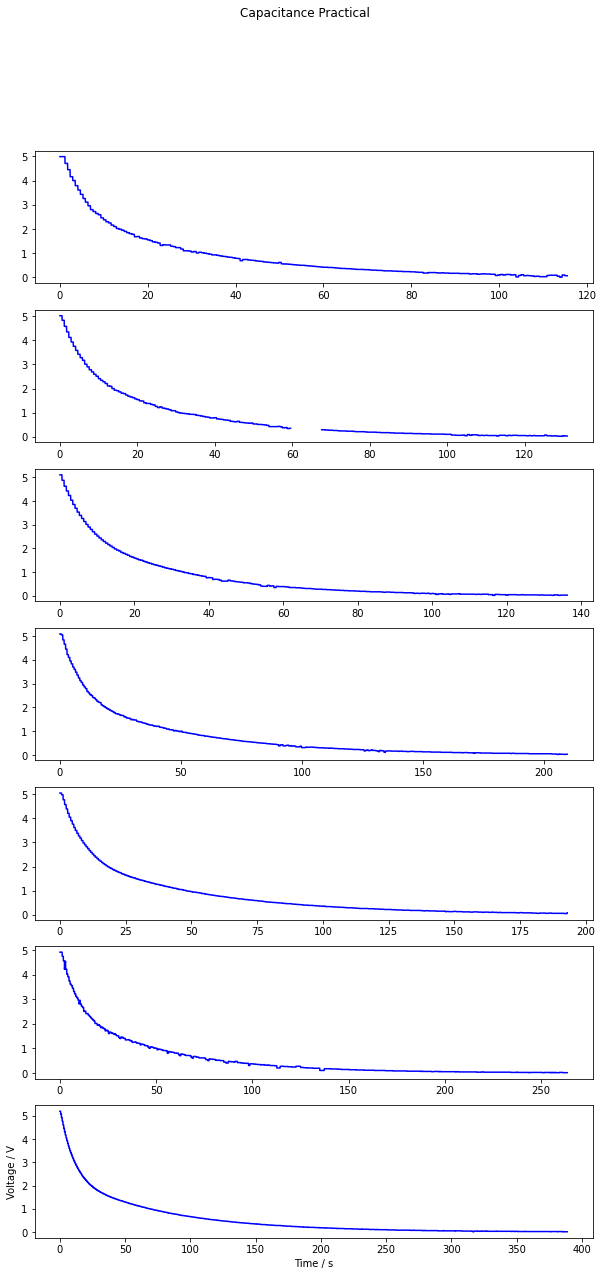

In [ ]:
fig, axs = plt.subplots(len(big_results) - 1)
fig.suptitle('Capacitance Practical')
fig.set_size_inches(10, 20)

fixed_results = []
for results in big_results:
    fixed_result = [int("".join(map(str, x))) / 100 for x in zip(*results) if any(x)]
    # fixed_result = [log(x) for x in fixed_result if x] 
    anomalies = []
    count = 1
    current = fixed_result[0]
    for i, x in enumerate(fixed_result[1:], start=1):
        if x == current:
            count += 1
        else:
            if count < 15:
                start = i - count
                if anomalies and start == anomalies[-1][1]:
                    anomalies[-1][1] = i
                else:
                    anomalies.append([i - count, i])
            current = x
            count = 1

    for start, end in anomalies:
        corrects = fixed_result[start - 1 if start else end], fixed_result[end]
        fixed_result[start: end] = [min(corrects) + abs(corrects[1] - corrects[0]) / (end - start) * i for i in range(end - start)]

    fixed_results.append(fixed_result)

csv_results = []
for i, (ax, fixed_result) in enumerate(zip(axs, [fixed_result for i, fixed_result in enumerate(fixed_results) if i != 2])):
    good = list(zip(*[(frame / 30, result) for frame, result in enumerate(fixed_result)]))
    csv_results.append(good)
    ax.plot(*good, 'b')
    if i == 1:
        sol = list(zip(*[(frame / 30, result) for frame, result in enumerate(fixed_results[2], start=len(fixed_result) + 240)]))
        csv_results[-1] = numpy.concatenate((csv_results[-1], list(zip(*[(frame / 30, "N/A") for frame in range(len(good), len(good) + 240)])), sol), axis=1)
        ax.plot(*sol, 'b')


plt.xlabel('Time / s')
plt.ylabel('Voltage / V')
plt.show()

In [ ]:
groups = {
    5.6: range(3),
    10: range(3, 6),
    10 + 5.6: range(6, 7)
}
groups = {r: list(group) for r, group in groups.items()}

for resistance, group in groups.items():
    with open(f"/content/drive/MyDrive/physicsPractical/results/{resistance} kΩ.csv", "w") as f:
        relevant = csv_results[group[0]: group[-1] + 1]
        shortest_times = min(relevant, key=lambda x: len(x[0]))[0]
        writer = csv.writer(f)
        for time, results in zip(shortest_times, zip(*[x[1] for x in relevant])):
            writer.writerow([time] + list(results))